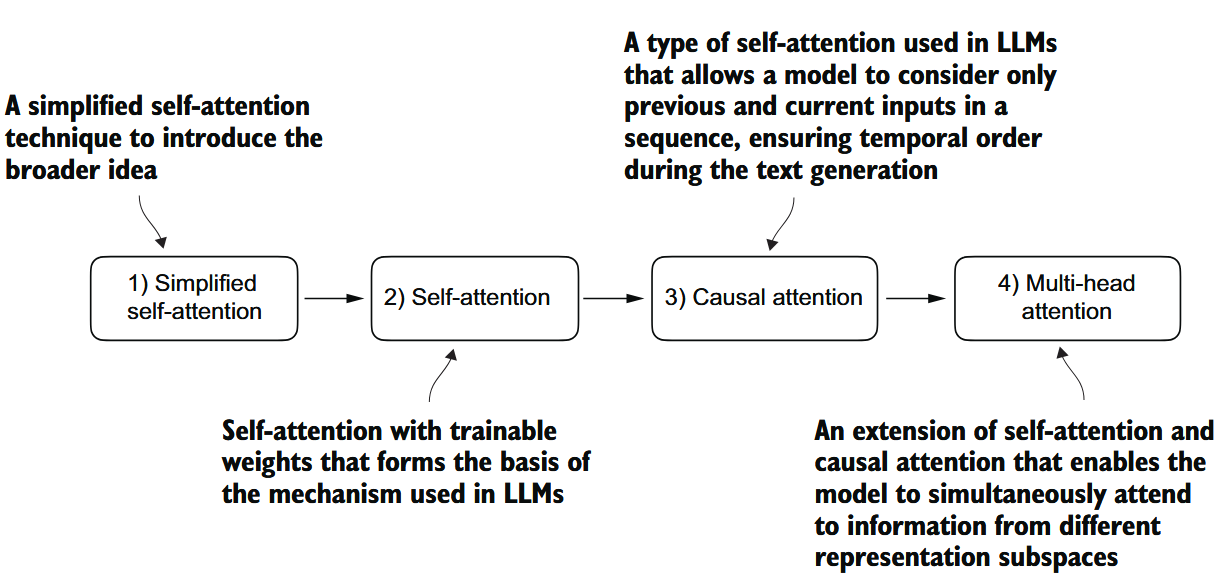

**Problem with modelling long sequences:**
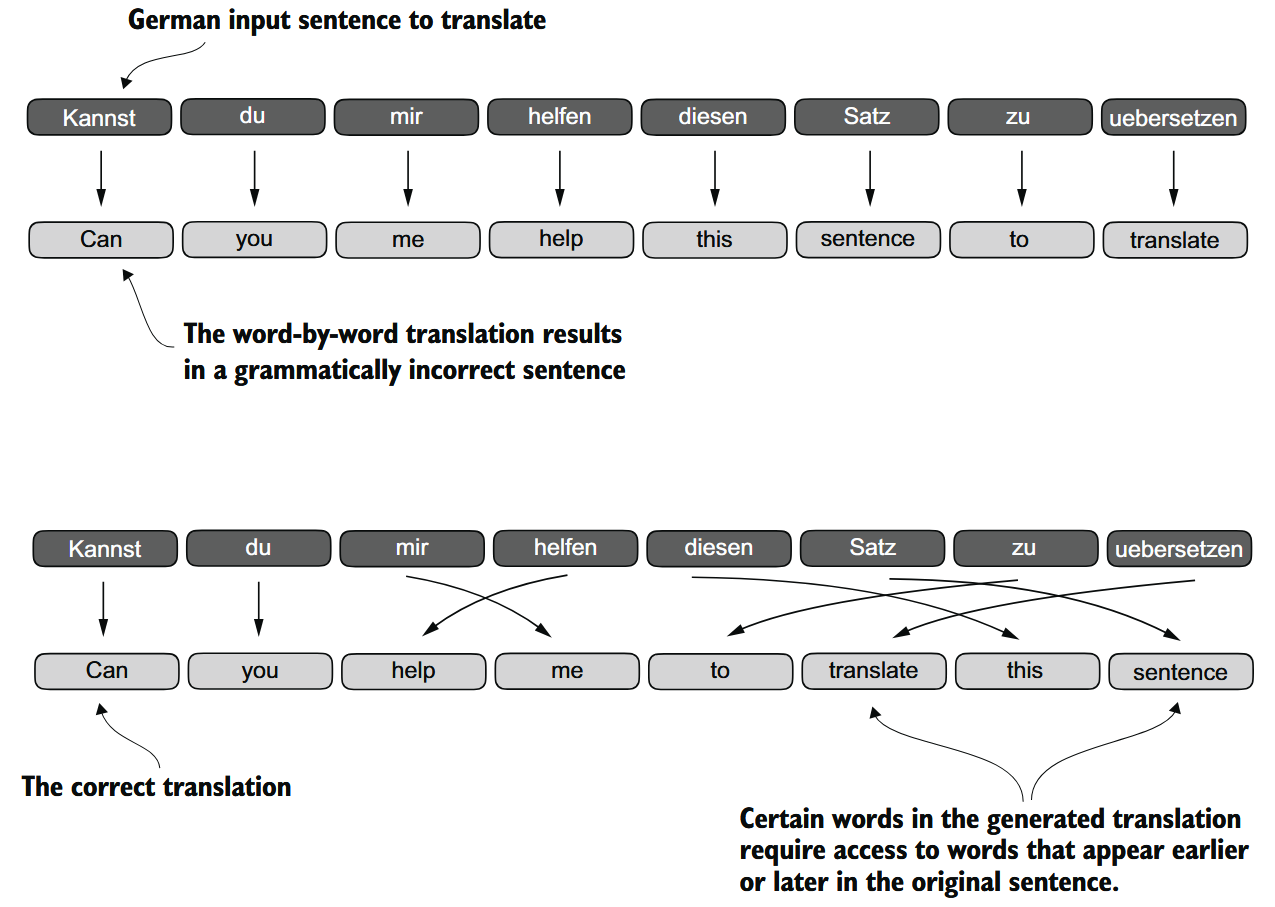

We can't simply translate word to word because of the grammetical structure in the source and the target language. To address this problem it is common to use a DNN with two submodules, an $encoder$ and a $decoder$. The job of the encoder is to read and process the entire text, and the decoder process the translated text.

**Problems with RNN:**
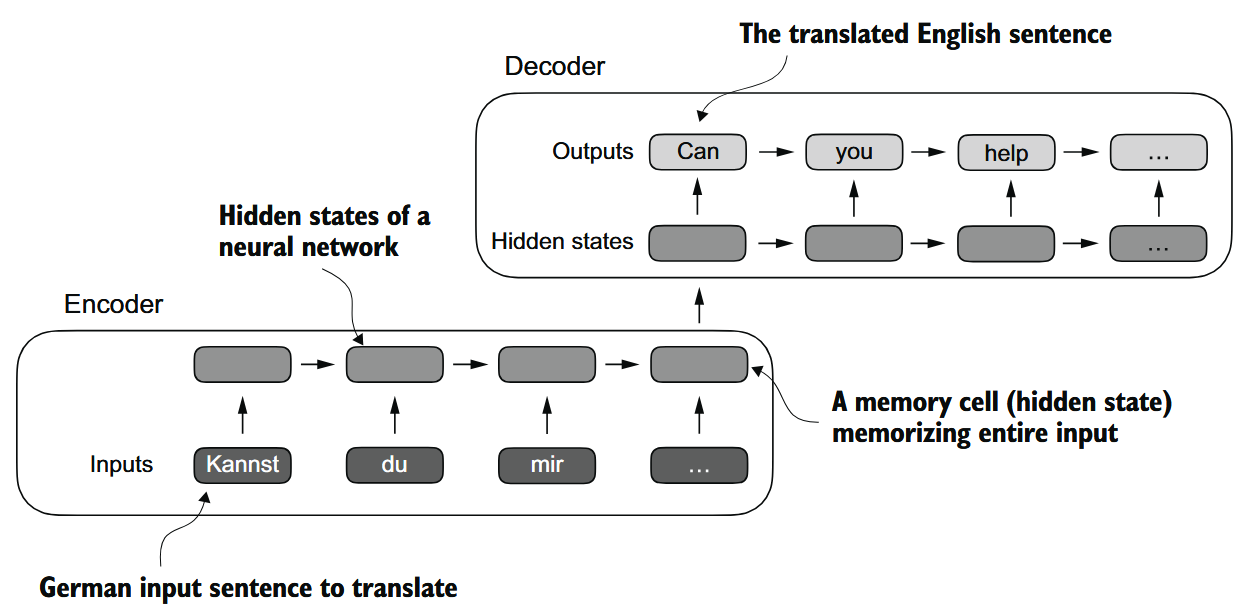

in encoder-decoder RNN, the input text is fed into the encoder which processess it sequentially. The encoder updates its hidden state at each step, trying to capture the entire meaning of the input sentence in the final hidden state.

The decoder then takes the final hidden state to start generating the translated sentence, one word at a time. It also updates the hidden state at each step, which is suppose to carry the context necessary for the next step

**Limitations:** RNN can't access earlier hidden states from the encoder during decoding phase. It relies solely on the current hidden phase, which encapsulates all the hidden information.This can lead to loss of context, especially in complex sentences where dependencies might span long distances.

**attention based mechanism:** It allowes the decoder of RNN to access different parts of the input sequence at each decoding step.
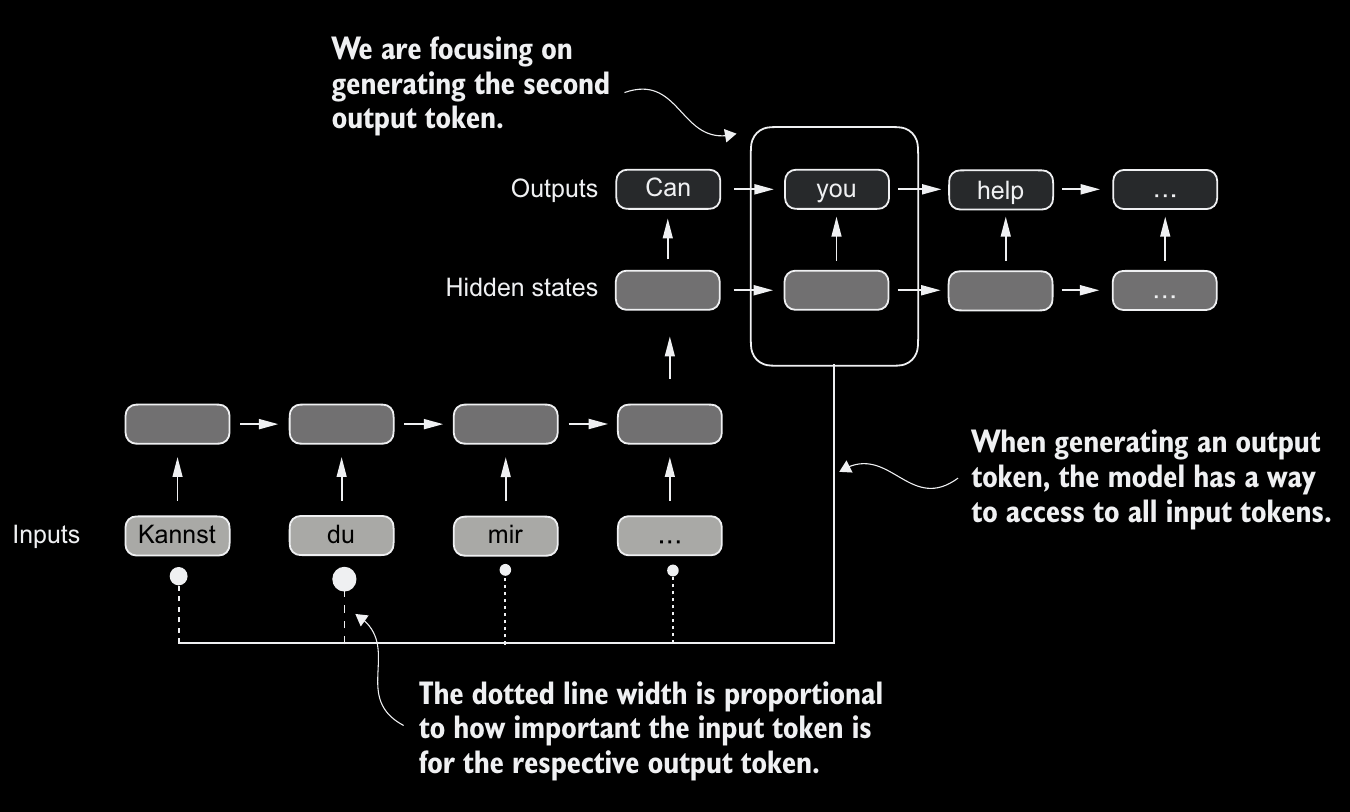

later it was found out that RNNs were not at all needed for NLPs

**Self-attention:** is a mechanism that allows each position in the input sequence to consider the relevancy of, or "attend to", all other position in the same sequence when computing the representation of a sequence. The "self" refers to the mechanism's ability to compute attention weights by relating to different position within a single input sequence. It assesses and learns the relationship and dependencies between various parts of the input itself.

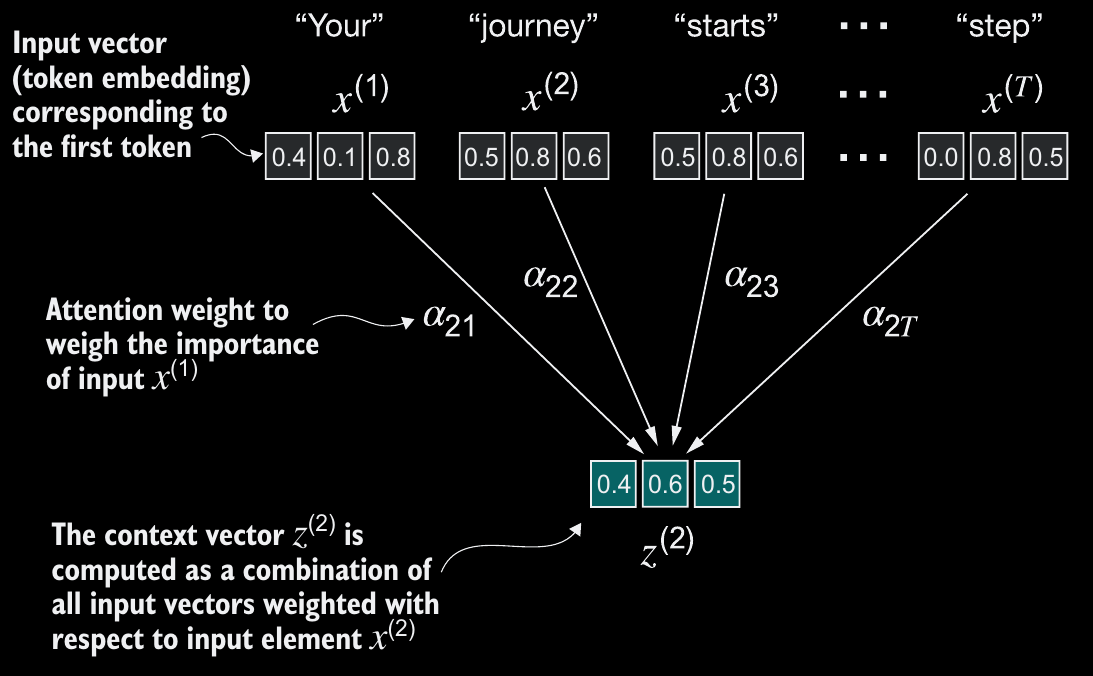

we will now train a simplefied version of the self-attention, free from any trainable weights.

The goal of self-attention is to compute a context vector for each input element that combines information from all other input elements. In the above image the context vector is $Z^2$. The importance or contribution of each input element for computing $Z^2$ is determined by attention weights $\alpha$<sub>21</sub> to $\alpha$<sub>2T</sub>.

In self-attention our goal is to calculate context vectors $z^i$ for each element $x^i$ of the input sequence. A *context vector* can be interpreted as enriched embedding vector(by incorporating information from all other elements in the sequence).  

In [215]:
# implementing a simplefied version of self-attention(without trainable weights)
import torch

In [216]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89],      # Your       (x^1)
 [0.55, 0.87, 0.66],      # journey    (x^2)
 [0.57, 0.85, 0.64],      # starts     (x^3)
 [0.22, 0.58, 0.33],      # with       (x^4)
 [0.77, 0.25, 0.10],      # one        (x^5)
 [0.05, 0.80, 0.55]]      # step       (x^6)
)

The first step of implementing self atention is to compute intermediate values $ω$, referred as attention score.

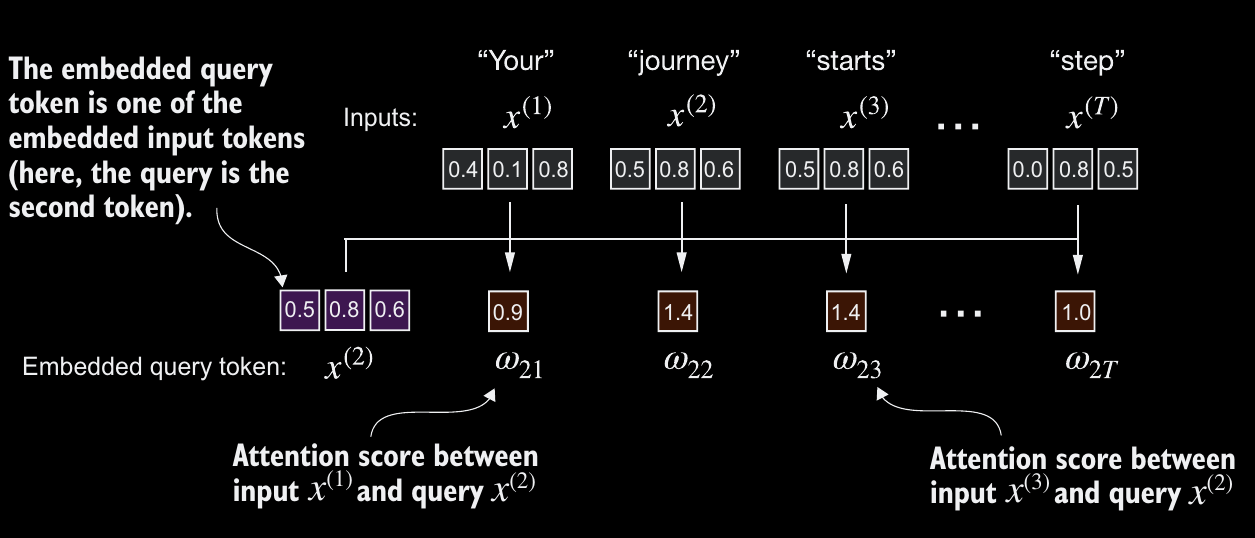

This figure shows calculating the attention scores between all other elements with respect to element 2.

In [217]:
# Attention scores is determined by computing the dot product of query, X^2 with every other input token
query = inputs[1] # second input token serves as query
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [218]:
# normalize each attention score. The main goal behind normalization is to get attantion scores that sum up to 1
attn_weights_2_temp = attn_scores_2/attn_scores_2.sum()
print("Attention weights: ",attn_weights_2_temp)
print("Sum: ", attn_weights_2_temp.sum())

Attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


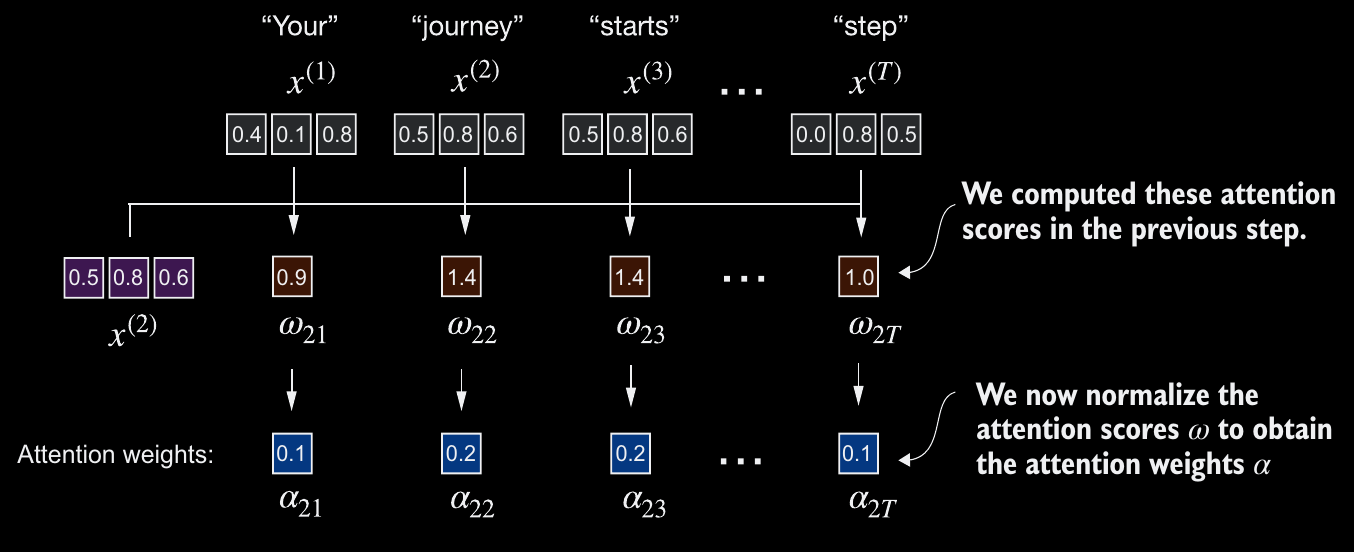

After obtaining attention scores the next step is to obtain attention weights by normalizing attention scores.

In [219]:
# It is much more advisable to use softmax function for normalization.
def softmax_naive(x):
  return torch.exp(x)/torch.exp(x).sum(dim = 0) # Softmax function ensures that the attention scores are always positive

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights: ", attn_weights_2_naive)
print("Sum: ", attn_weights_2_naive.sum())

Attention weights:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [220]:
# Naive implementation of softmax may encounter numerical instability problems such as overflow or underflow when dealing with larger or small input values.
attn_weights_2 = torch.softmax(attn_scores_2, dim = 0)
print("Attention weights: ", attn_weights_2)
print("Sum: ", attn_weights_2.sum())

Attention weights:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [221]:
# Context vector Z^2 is the weighted sum of all input vectors, obtained by multiplying each input vector by its corresponding attention weight:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


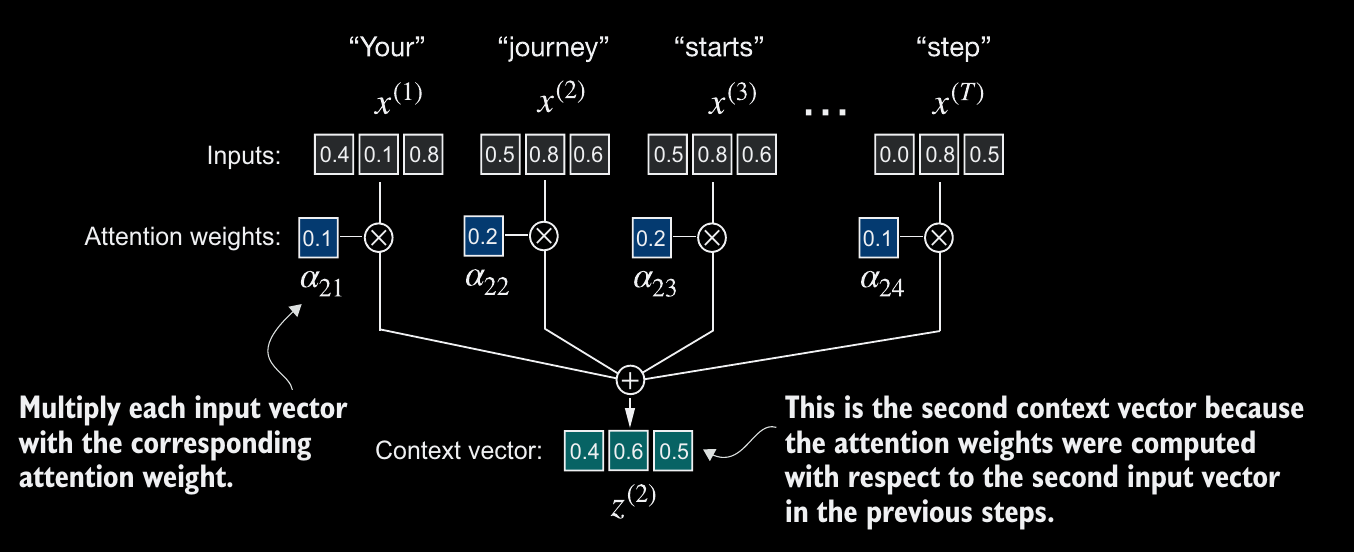

Now we will apply the same things but to all other input tensors

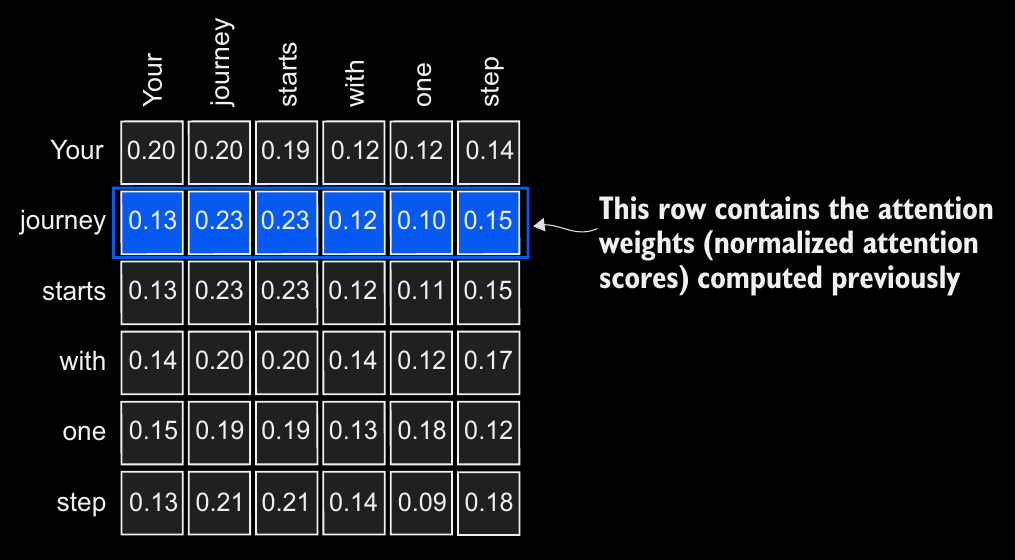

In [222]:
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
  for j, x_j in enumerate(inputs):
    attn_scores[i,j] = torch.dot(x_i,x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


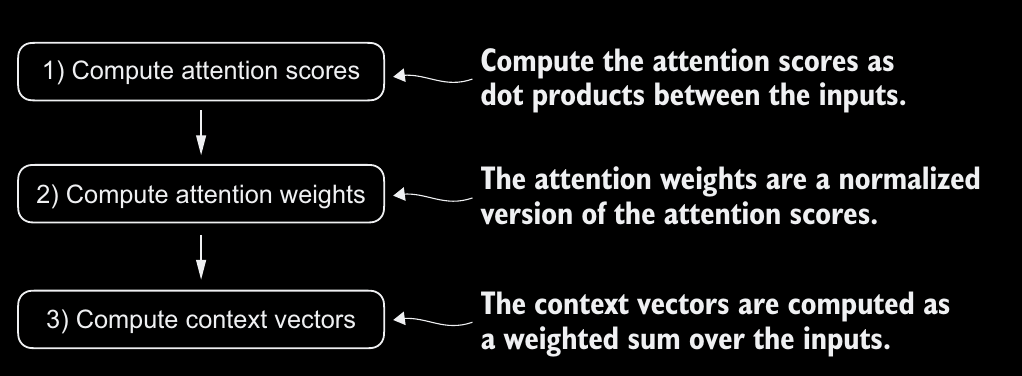

In [223]:
# Since for loops are slow we use matrix multiplication
attn_scores = inputs@inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [224]:
# step 2 of the above figure
attn_weights = torch.softmax(attn_scores, dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [225]:
all_context_vec = attn_weights@inputs
print(all_context_vec)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


Now we will implement self-attention with trainaible weights

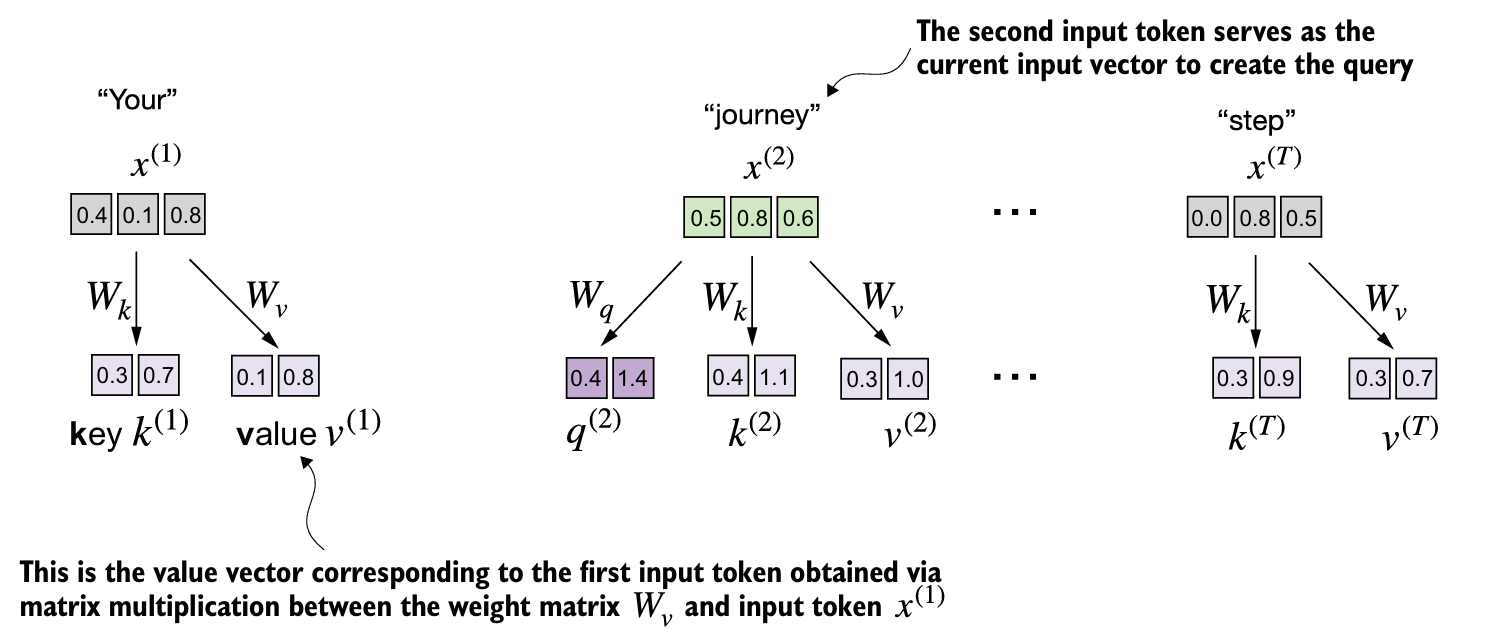

We will implement self-attention by introducing the three trainable weight matrices $W$<sub>$q$</sub>, $W$<sub>$k$</sub>, $W$<sub>$v$</sub>. These three matrices are used to project the embedded input tokens $x^i$, into query, key and value vectors respectively

In the above image the value vector corresponding to the first token input token, $v^1$ is obtained via matrix multiplication of $W$<sub>$v$</sub> with the input token $x^1$.

In [226]:
# For simple understanding, I started by computing only one context vector first.
x_2 = inputs[1] # The second input element
d_in = inputs.shape[1] # The input embedding size
d_out = 2 # The output embedding size

In [227]:
print(inputs.shape)

torch.Size([6, 3])


In [228]:
# Now we initialize three weight matrices
torch.manual_seed(123)
w_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad = True)
w_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad = True)
w_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad = True)
print(w_key.shape)
query_2 = x_2@w_query
key_2 = x_2@w_key
value_2 = x_2@w_value
print(query_2)

torch.Size([3, 2])
tensor([0.4306, 1.4551], grad_fn=<SqueezeBackward4>)


Weight parameters are not to be confused with attention weights. Weight parameters are fundamental learnt coefficient that determine network connections while attention weights are dynamic, context specific values

In [229]:
# To calculate the attention score of element 2 w.r.t all other elements we need to calculate their key and value pair
keys = inputs @ w_key
values = inputs @ w_value

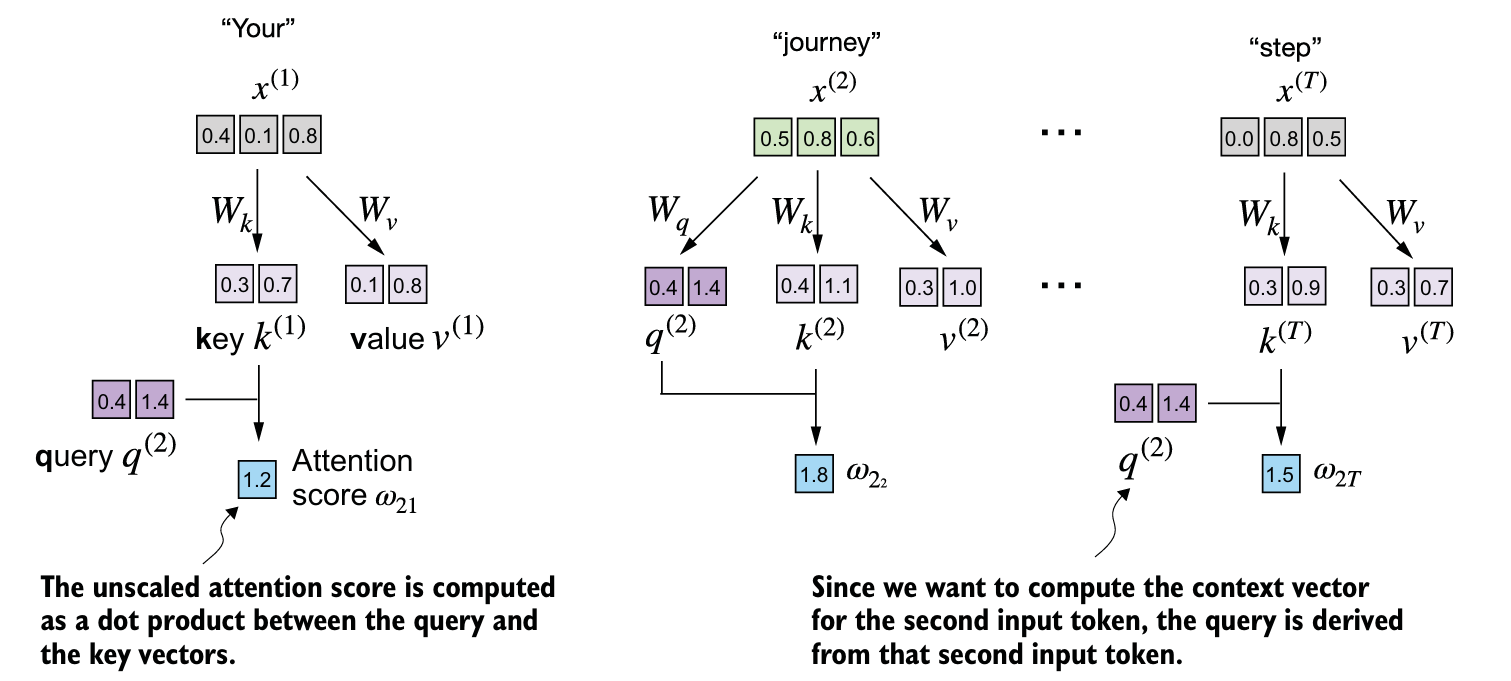

In this attention mechanism we are not directly computing the dot product between the input elements but using the query and key obtained by transforming the inputs via the respective weight matrices.

In [230]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524, grad_fn=<DotBackward0>)


In [231]:
# Generalizing this computation to all attention scores via matrix multiplication
atten_scores_2 = query_2@keys.T
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [232]:
# Now we go from calculating the attention score to calculating the attention weights
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2/d_k**0.5, dim = -1)
print(attn_weights_2)

tensor([0.1476, 0.2164, 0.2134, 0.1365, 0.1240, 0.1621])


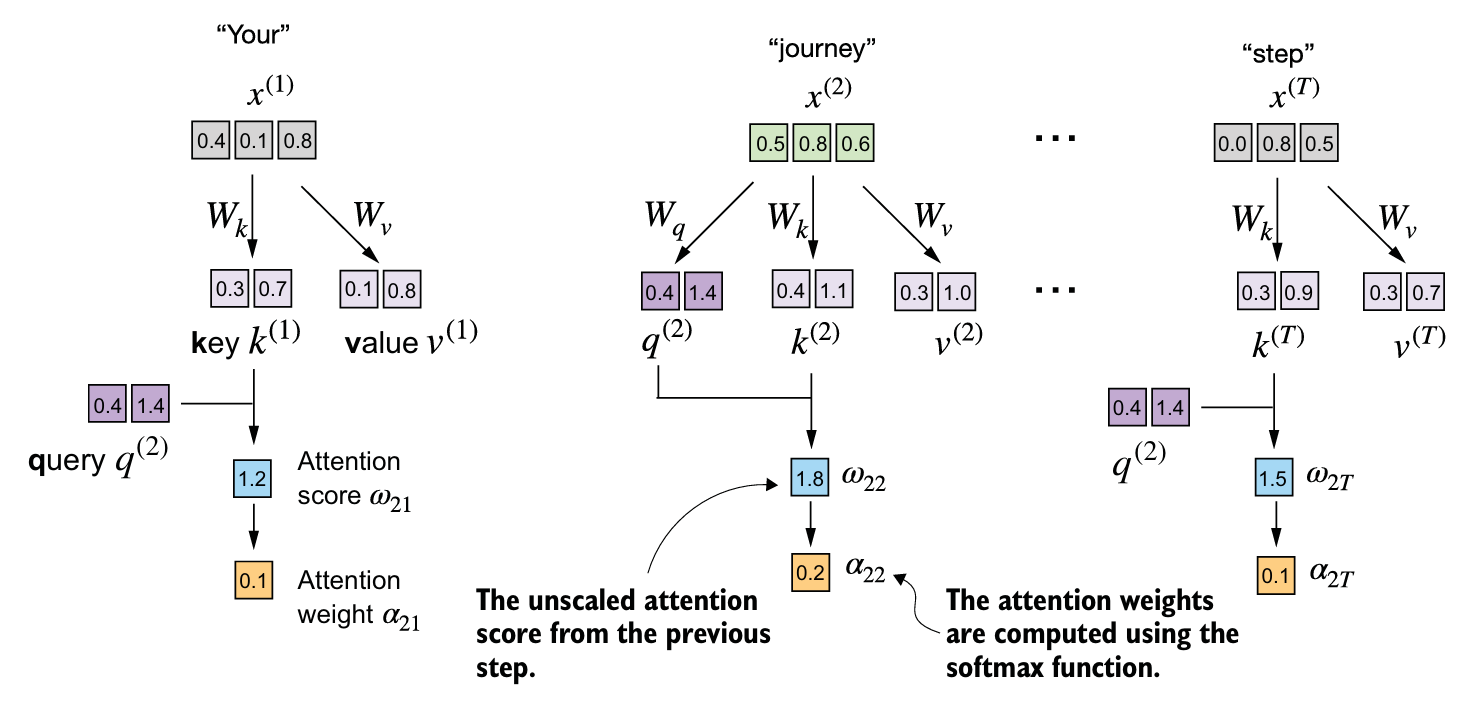

---
**Why divide by $d$<sub>$k$</sub>**:

 The reason for the normalization by the embedding dimension size is to improve the
 training performance by avoiding small gradients. For instance, when scaling up the
 embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large
 dot products can result in very small gradients during backpropagation due to the
 softmax function applied to them. As dot products increase, the softmax function
 behaves more like a step function, resulting in gradients nearing zero. These small
 gradients can drastically slow down learning or cause training to stagnate

 ---

Now the final step is to compute the context vectors

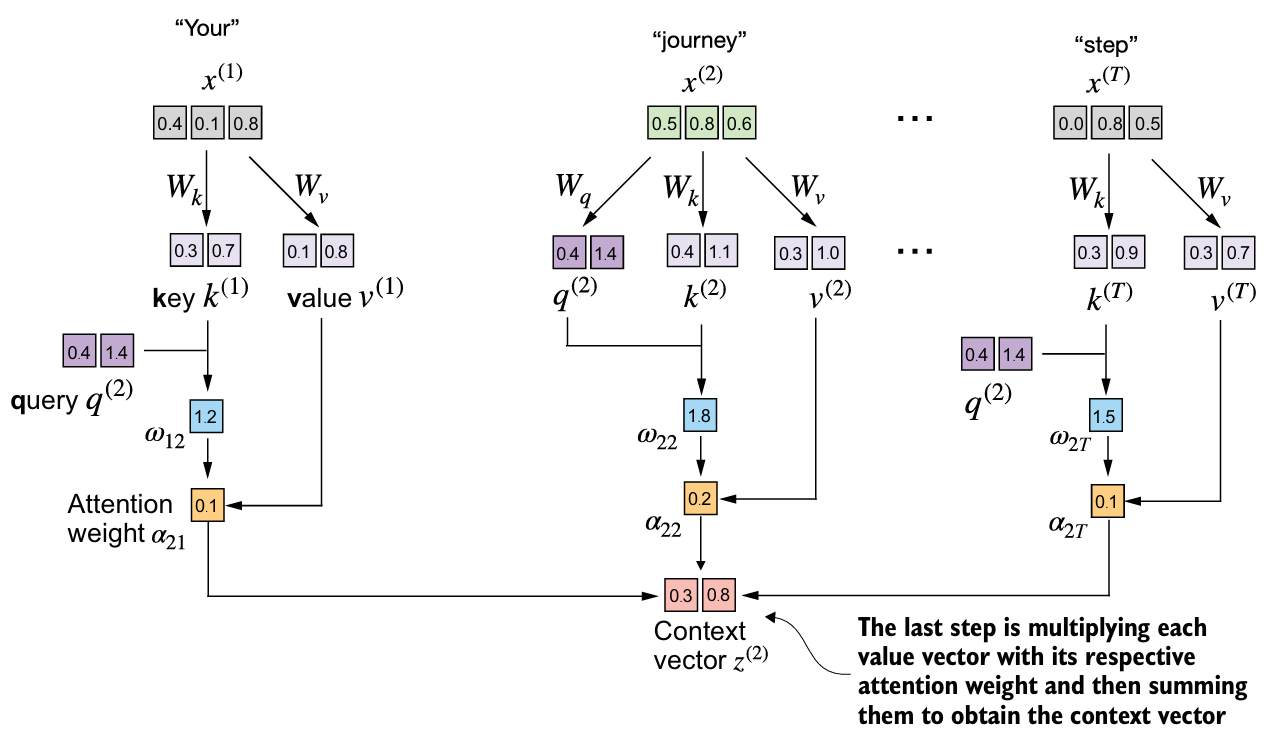

We now compute the context vector as a weighted sum over value vectors. Here the attention weights serves as a weighting factor that weights the respective importance of each value vector.

In [233]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.2991, 0.8010], grad_fn=<SqueezeBackward4>)


Now we will generalize what we have studied to all other vectors

---
**Why query, key and value?**

 The terms “key,” “query,” and “value” in the context of attention mechanisms are
 borrowed from the domain of information retrieval and databases, where similar con
cepts are used to store, search, and retrieve information.

 A query is analogous to a search query in a database. It represents the current item
 (e.g., a word or token in a sentence) the model focuses on or tries to understand.
 The query is used to probe the other parts of the input sequence to determine how
 much attention to pay to them.

 The key is like a database key used for indexing and searching. In the attention mech
anism, each item in the input sequence (e.g., each word in a sentence) has an asso
ciated key. These keys are used to match the query.

The value in this context is similar to the value in a key-value pair in a database. It
 represents the actual content or representation of the input items. Once the model
 determines which keys (and thus which parts of the input) are most relevant to the
 query (the current focus item), it retrieves the corresponding values.

---

### Implementing a compact self-attention class

In [234]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self,d_in,d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(d_in, d_out))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out))

  def forward(self,x):
    keys = x @ self.W_key
    queries = x @ self.W_query
    values = x @ self.W_value
    attn_scores = queries @ keys.T # omega
    attn_weights = torch.softmax(
        attn_scores/keys.shape[-1]**0.5, dim = 1
    )
    context_vec = attn_weights @ values
    return context_vec

In [235]:
# Using the above function
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out) # (d_in,d_out) --> (3,2)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


**Self-attention summary:**
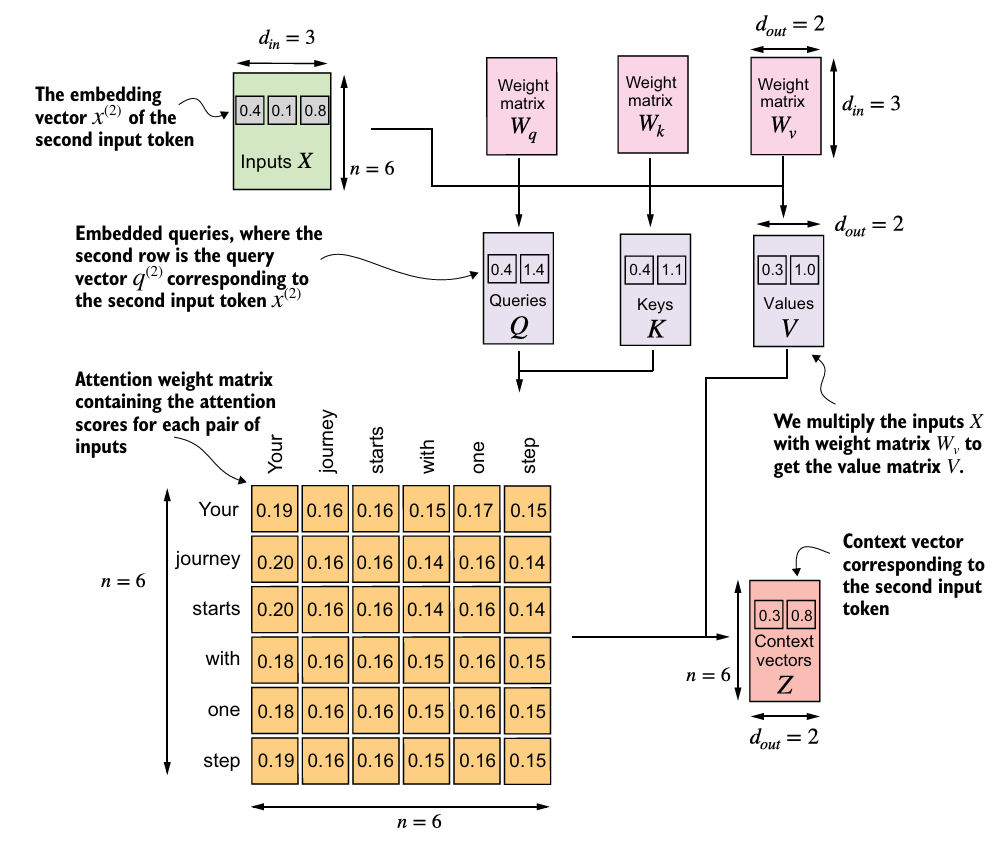

Self-attention includes the trainaible weight matrices $W$<sub>$q$</sub>, $W$<sub>$k$</sub>, $W$<sub>$v$</sub>. These matrices transform input data into queries, keys and values respectively which are crucial componentsof the attention mechanism.

We can further imporve the SelfAttention_v1 implemention by utilising PyTorch's nn.Linear layers which effectively performs matrix multiplication when the bias are disables. Another significant advantageis that instead of manually implementing nn.Parameter(torch.rand(d_in, d_out)) is that nn.Linear has an optimized weight initialization shceme

In [236]:
class SelfAttention_v2(nn.Module):
  def __init__(self,d_in,d_out):
    super().__init__()
    self.W_query = nn.Linear(d_in,d_out, bias = False)
    self.W_key = nn.Linear(d_in,d_out, bias = False)
    self.W_value = nn.Linear(d_in,d_out, bias = False)

  def forward(self,x):
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)
    attn_scores = queries@keys.T
    attn_weights = torch.softmax(
        attn_scores/keys.shape[-1]**0.5,dim = 1
    )
    context_vec = attn_weights @ values
    return context_vec

In [237]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs)) # This gives previous output than the previous one because nn.Linear() has a complex weight initialization scheme

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


### Casual and multi-head attention

The casual aspect involves modifying the attention mechanism to prevent the model from accessing future information in the sequence, which is crucial for tasks like language modeling, where each word prediction only depend on previous words.

The multi-head component involves splitting the attention mechanism into multiple "heads." Each head learns different aspect of the data, allowing the model to simultaneously attend to information from different representations subspaces at different position

For many LLM tasks you will want the self-attention mechanism to consider only the tokens that appear prior to the current position when predicting the next token in a sequence. Casual attention also known as ***masked attention***, is a specilized form of self-attention. It restricts model to only consider previous and current inputs in a sequence when processing any given token wehn computing attention scores

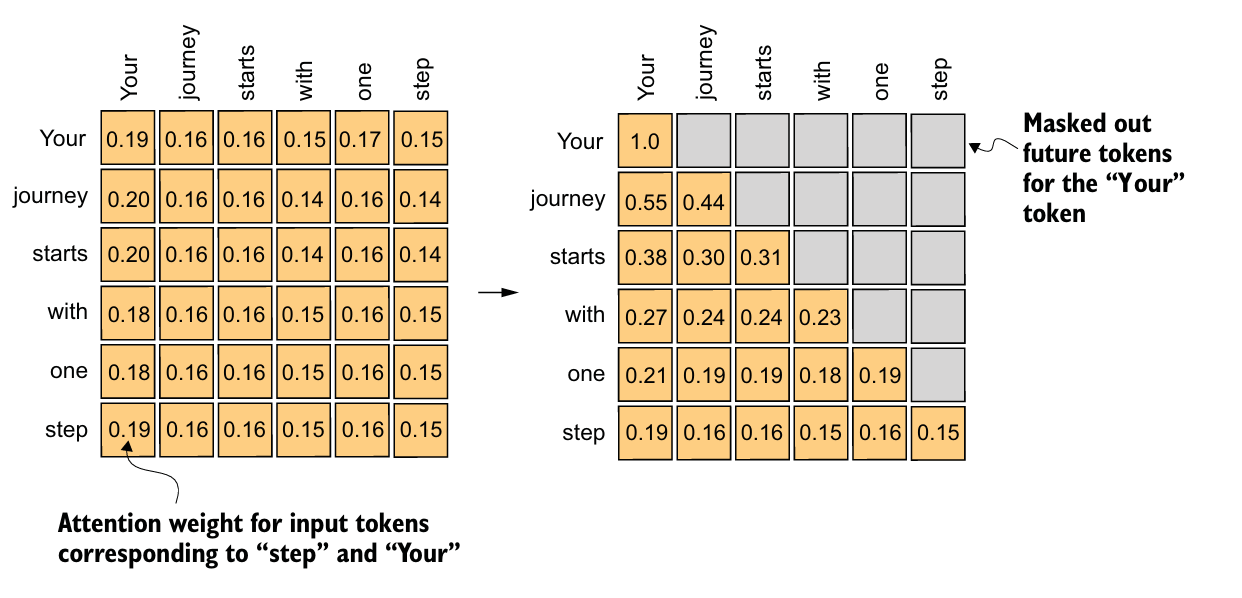

We mask the attention weights above the diagonal and then we normalize the non-masked attention weights

In [238]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim =-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [239]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [240]:
masked_sample = attn_weights*mask_simple
print(masked_sample)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [241]:
# Renormalize the attention weights
row_sums = masked_sample.sum(dim = -1, keepdim = True)
masked_sample_norm = masked_sample/row_sums
print(masked_sample_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


A better way to perform the mask the attention weights is by replacing the above diagonal values with $(-∞)$ values, the softmax will automatically treat them as zero probability.

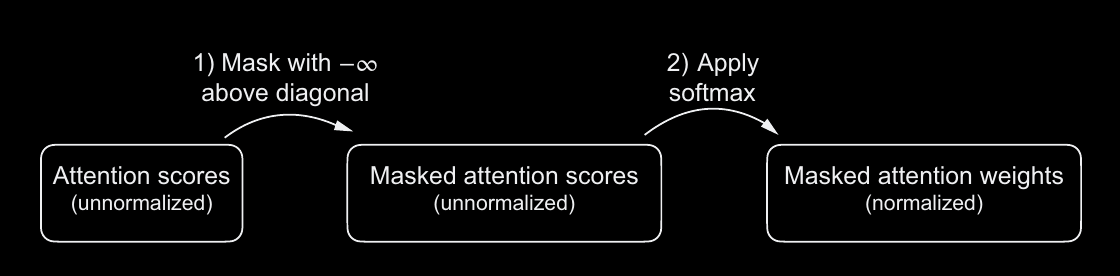

In [242]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal = 1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [243]:
attn_weights = torch.softmax(masked/keys.shape[-1]**0.5, dim = 1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [244]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # Using this dropout means masking half of out attention weights
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


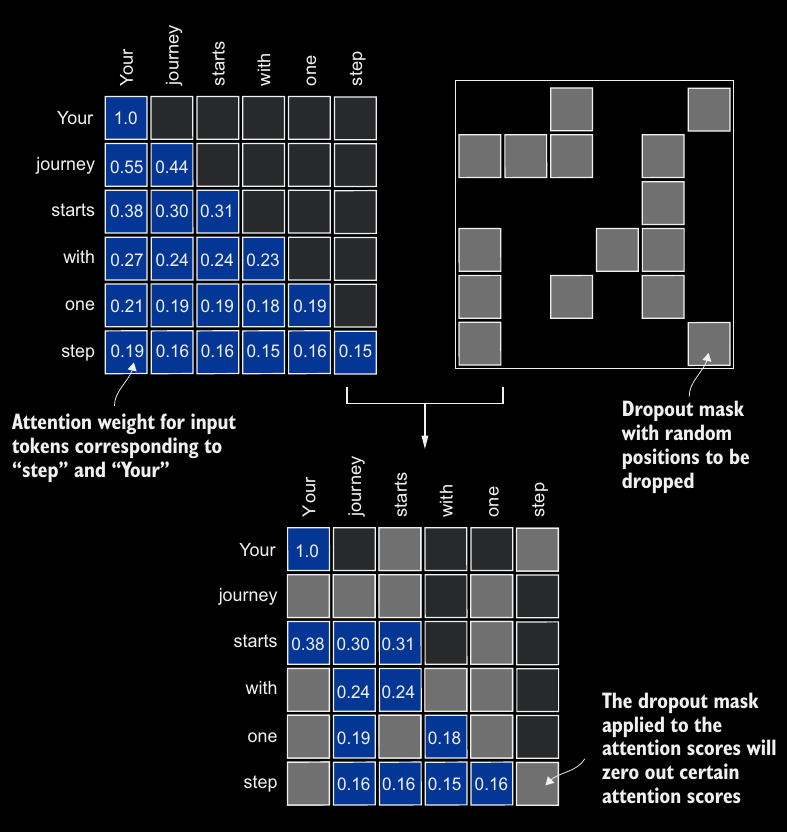

Using casual attentio mask, we apply an additional dropout mask(upper right) to zero out additional attention weights to reduce overfitting during training

In [245]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


In [246]:
# Before we incorporate the final class we gotta make sure that our code can handle batches consisting of more than one input
batch = torch.stack((inputs, inputs), dim = 0)
print(batch.shape)

torch.Size([2, 6, 3])


In [247]:
class CasualAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,
               dropout,qkv_bias = False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in,d_out,bias = qkv_bias)
    self.W_key = nn.Linear(d_in,d_out, bias = qkv_bias)
    self.W_values = nn.Linear(d_in,d_out,bias = qkv_bias)
    self.dropout = nn.Dropout(dropout) # Compared to the previous attention class we added dropout layer
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length,context_length),
                   diagonal = 1)
    )
  def forward(self,x):
    b,num_tokens,d_in = x.shape
    keys = self.W_key(x)
    query = self.W_query(x)
    values = self.W_values(x)
    attn_scores = queries @ keys.transpose(1,2)
    attn_scores.masked_fill_(
          self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
      )
    attn_weights = torch.softmax(
          attn_scores/keys.shape[-1]**0.5, dim = -1
      )
    attn_weights = self.dropout(attn_weights)
    context_vec = attn_weights @ values
    return context_vec


The use of `register_buffer` is not strictly necessary but offeres some advantage: Let say when we create an instance of the `CasualAttention` class in out LLM, buffers are automatically moved to the appropriate device(CPU or GPU) along with our model. This means that we don't need to manually ensure that tensors are on the same device as your model parameters, avoiding device mismatch errors

In [248]:
# Using CasualAttention class
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_length, 0.0)
context_vector = ca(batch)
print(context_vector.shape)

torch.Size([2, 6, 2])


### Multi-head Attention:
The term 'multihead' refers to dividing the attention mechanism into multiple 'heads', each operating independently. In this context, a single casual attention modeule can be considered a single head attention, where only one set of attention head is processing the input sequentially

We will build a multi-head attention modelue by stacking multiple casualAttention module. Then we will build same multi-head in a more complicated and computer efficient way.

Implementing multi-head attention involves creating multiple instances of the self-attention mechanism, each with its own weights, and then combining their outputs. Using multiple instances of the self attention mechanism can be computationally intensive but its crucial for pattern recoginition model like LLMs.



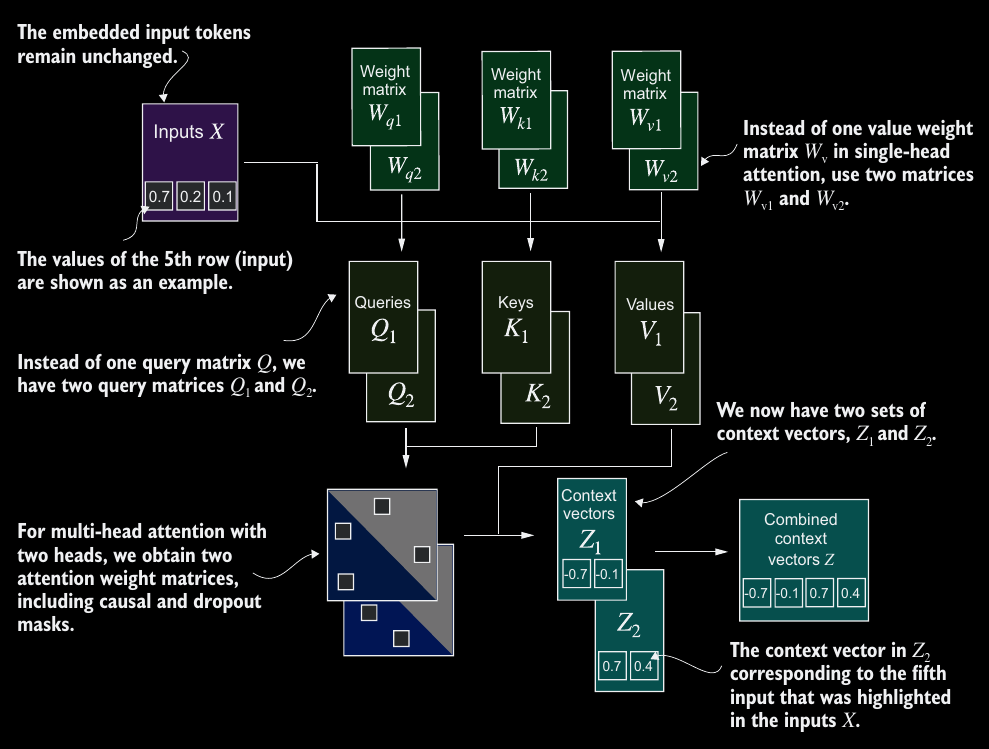

(above pic)The multi-head attention module includes two single-head attention modules stacked on top of
each other. So, instead of using a single matrix Wv for computing the value matrices, in a multi-head attention
module with two heads, we now have two value weight matrices: Wv1 and Wv2. The same applies to the other
weight matrices, WQ and Wk. We obtain two sets of context vectors Z1 and Z2 that we can combine into a single
context vector matrix Z.

In [249]:
# A wrapper class to implement multi-head attention
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length,
               dropout, num_heads, qkv_bias = False):
    super().__init__()
    self.heads = nn.ModuleList(
        [CasualAttention(d_in, d_out, context_length, dropout, qkv_bias)
        for _ in range(num_heads)]
    )

  def forward(self, x):
    return torch.cat([head(x) for head  in self.heads], dim = -1)

In [250]:
# Using multi-head attention class
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3,2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length,0.0, num_heads = 2)
context_vector = mha(batch)
print(context_vector)
print("Context Vector shape: ", context_vector.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5741,  0.0270,  0.5742,  0.2966],
         [-0.6184, -0.0446,  0.6075,  0.3612],
         [-0.5556, -0.0794,  0.5418,  0.3481],
         [-0.5425, -0.0966,  0.5291,  0.3382],
         [-0.5177, -0.1054,  0.5021,  0.3406]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5741,  0.0270,  0.5742,  0.2966],
         [-0.6184, -0.0446,  0.6075,  0.3612],
         [-0.5556, -0.0794,  0.5418,  0.3481],
         [-0.5425, -0.0966,  0.5291,  0.3382],
         [-0.5177, -0.1054,  0.5021,  0.3406]]], grad_fn=<CatBackward0>)
Context Vector shape:  torch.Size([2, 6, 4])


**An efficient implementation of multi-head attention class:** The following multi-head attention class integrates the multi-head functionality withing a single class.

It splits the input into multiple head by rehaping the projected query, key, and value tensors and then combines the results from these heads after computing attention.

In [251]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert (d_out % num_heads ==0), \
    "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads # Reduces the projection dim to match the desired output
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.out_proj = nn.Linear(num_heads*d_out, d_out) # Uses a linear layer to combine the head outputs
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),
                   diagonal = 1)
    )

  def forward(self,x):
    b, num_tokens, d_in = x.shape # Tensor shape: (b, num_tokens, d_out)
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # This function returns the same tensor but with a different shape
    values = values.view(b, num_tokens, self.num_heads, self.head_dim) # The matrix is being explicitly split here by adding a num_heads dim
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1,2) # (b, num_token, num_heads, head_dim) --> (b, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1,2) # (b, num_token, num_heads, head_dim) --> (b, num_heads, num_tokens, head_dim)
    values = values.transpose(1,2) # (b, num_token, num_heads, head_dim) --> (b, num_heads, num_tokens, head_dim)

    attn_scores = queries @ keys.transpose(2,3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Masks truncated to the number of tokens

    attn_scores.masked_fill_(mask_bool, -torch.inf) # Uses masks to fill attention scores

    attn_weights = torch.softmax(
        attn_scores/keys.shape[-1]**0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1,2) # (b, num_tokens, n_heads, head_dim) essential

    # Combines heads, where self.d_out = self.num_heads*self.head_dim
    context_vec = context_vec.contiguous().view(
        b, num_tokens, self.d_out
        )
    context_vec = self.out_proj(context_vector) # Adds an optional linear projection
    return context_vec

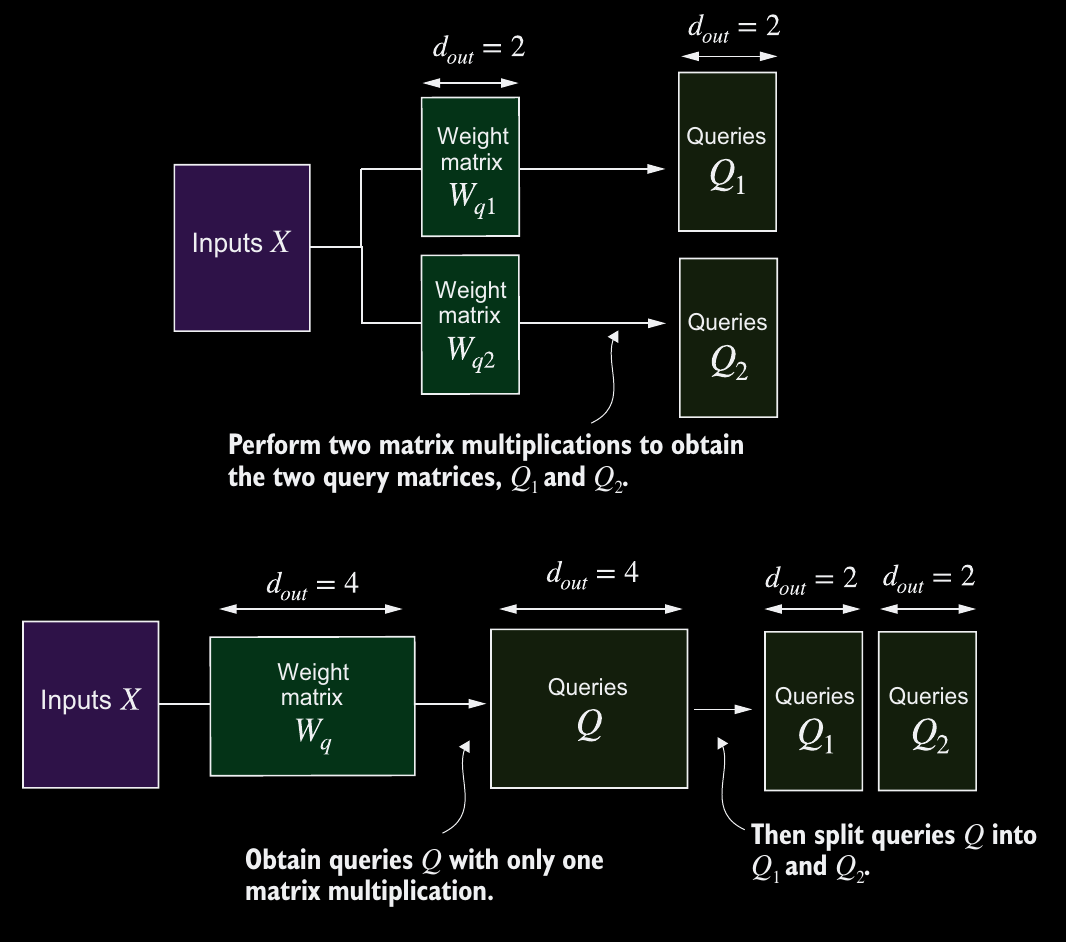

This MultiHeadAttentionClass starts with multi-head layer and then internally splits this layer into individual attention heads.

The splitting of query, key and value tensors is achieved through reshaping and transposing opterations using `view()` and `transpose()` methods. The input is first transformed (via linear layers for query, keys and values) and then reshaped to represent multiple heads.


In [252]:
# For illustration
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                    [[0.0772, 0.3565, 0.1479, 0.5331],
                     [0.4066, 0.2318, 0.4545, 0.9737],
                     [0.4606, 0.5159, 0.4220, 0.5786]]]]) # shape of this tensor is (b, num_heads, num_tokens, head_dim
print("a shape: ",a.shape)
print(a @ a.transpose(2,3))

a shape:  torch.Size([1, 2, 3, 4])
tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [253]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)
second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


In [254]:
# Using multi-head attention
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.0450, 0.3117],
         [0.0802, 0.2093],
         [0.0917, 0.1715],
         [0.0543, 0.1760],
         [0.0446, 0.1708],
         [0.0309, 0.1764]],

        [[0.0450, 0.3117],
         [0.0802, 0.2093],
         [0.0917, 0.1715],
         [0.0543, 0.1760],
         [0.0446, 0.1708],
         [0.0309, 0.1764]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])
